## Prognose der Erfolgschance einer telefonischen Marketing-Kampagne 
Autor: Armin Müller

Im Folgenden wird ein Modell zur Prognose der Erfolgschance einer telefonischen Marketing-Kampagne zum Verkauf von Termineinlagen entwickelt. Als Datengrundlage dient ein frei verfügbarer Datensatz aus dem UC Irvine Machine Learning Repository. Der Datensatz kann [hier](https://archive.ics.uci.edu/dataset/222/bank+marketing) eingesehen werden. Mit Hilfe des Datensatzes, welcher auf einer realen durchgeführten Kampagne basiert, wird ein decision tree learning Modell trainiert. Ziel ist es, für zukünftige Kampagnen eine Einschränkung der Zielgruppe vornehmen zu können, und so Ressourcen einzusparen. Dazu wird der Datensatz analysiert und für das Training vorbereitet. Das Modell wird traininert und anschließend anhand der Erkennungsquote für erfolgreich kontaktierte Personen (Recall) sowie der Quote von False Positives beurteilt.

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import sklearn
from imblearn.over_sampling import RandomOverSampler
import seaborn as sb

Zunächst wird der Datensatz geladen. Hierfür stellt die UC Irvine eine eigene Library zur Verfügung. Der Datensatz kann alternativ auch manuell heruntergeladen und dann importiert werden

In [2]:
bank_marketing = fetch_ucirepo(id=222) 
features = bank_marketing.data.features 
targets = bank_marketing.data.targets
# Falls die Daten lokal geladen werden sollen, bitte die folgenden beiden Zeilen auskommentieren und Dateipfade einfügen
#features = pd.read_csv(feature_url)
#targets = pd.read_csv(target_url)
data = pd.concat([features, targets], axis=1)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


Der Datensatz wird auf Vollständigkeit überprüft. Es zeigt sich, dass für die Features job, education, contact und poutcome fehlende Werte vorliegen.

In [3]:
data.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

Da die fehlenden Werte für job und education nur verhältnismäßig wenige Datensätze betreffen, werden diese entfernt. \
Das Feature contact fehlt für knapp ein Drittel der Datensätze. Der Einfachheit halber und da vermutet wird, dass diese Ausprägung keine große Auswirkung auf die Modellprognose hat, wird das Feature komplett entfernt. \
Der Datensatz poutcome weißt sehr viele fehlende Werte auf. In diesem Fall handelt es sich fachlich jedoch nicht um fehlende Werte, sondern um noch nicht in einer vorherigen Kampagne kontaktiere Personen. Aus diesem Grund wird das Feature nicht explizit weiterbehandelt, spätere Schritte zur Datenvorbereitung transformieren die Ausprägung in einen für das Training benutzbaren Wert. \
Weiter ist zu beachten, dass die Features duration, campaign, month und day_of_week erst nach Beendigung der Kampagne bzw. nach dem letzten Kontakt mit jeder Person bekannt sind. Sie eignen sich somit nicht für die hier beschriebene a-priori Untersuchung und werden aus diesem Grund entfernt.

In [4]:
data.drop(['duration', 'campaign', 'month', 'day_of_week', 'contact'], axis = 1, inplace = True)
data.dropna(subset=["job"], axis=0, inplace = True)
data.dropna(subset=["education"], axis=0, inplace = True)
data.reset_index(drop=True, inplace=True)

Einige Features liegen als kategorische Werte vor. Diese werden per one-hot encoding für das Modelltraining umgewandelt. Außerdem wird die Benennung der Target-Spalte angepasst.

In [5]:
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
encoder = sklearn.preprocessing.OneHotEncoder(drop="first", sparse_output = False)
encoded_features = encoder.fit_transform(data[categorical_columns])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
prepped_data = pd.concat([data.drop(columns=categorical_columns), encoded_data], axis=1)
prepped_data.rename(columns = {"y_yes": "success"}, inplace = True)

Der vorbereitete Datensatz wird nun auf Korrelation mit der Zielspalte untersucht. Es zeigt sich, dass die größte Korrelation zum Erfolg vorheriger Kampagnen gegeben ist. \
Eine Betrachtung der absoluten Were zeigt aber auch, dass es kein Feature gibt, welches eine starke Korrelation mit der Zielvariablen aufweist. Das deutet darauf hin, dass eine erfolgreiche Prognose der Zielvariablen schwierig ist.

<Axes: >

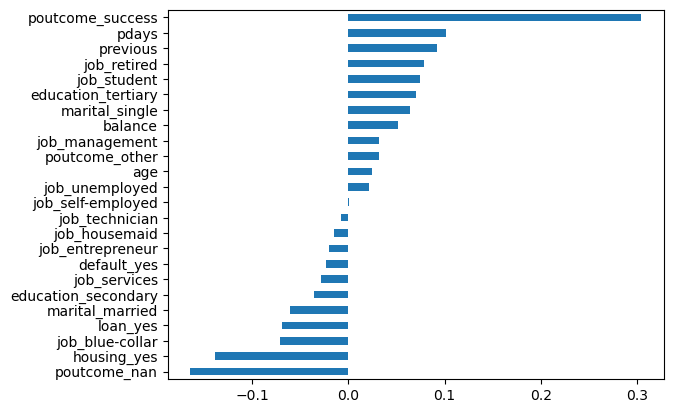

In [6]:
correlation_values = prepped_data.corr()['success'].drop('success').sort_values()
correlation_values.plot(kind='barh')

Der Datensatz wird nun in einen Trainings- und einen Testdatensatz aufgeteilt. Um die Ergebnisse der Untersuchung konsistent zu halten, wird der Split-Methode ein Random Seed mitgegeben.
Der Datensatz wird weiterhin auf ein Gleichgewicht der Ausprägungen untersucht

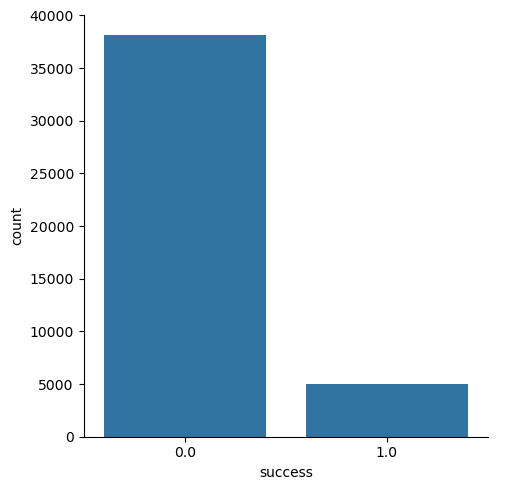

In [7]:
X = prepped_data.drop('success', axis=1)
y = prepped_data['success']
X_trainset, X_testset, y_trainset, y_testset = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=31)
sb.catplot(x = 'success',kind='count',data=prepped_data)

Es zeigt sich, dass der Datensatz sehr unausgewogen ist - es liegen deutlich weniger Datensätze zu einem erfolgreichen als zu einem nicht erfolgreichen Kontakt vor. Um einem starken Bias des Modells entgegenzuwirken, werden Datensätze mit Zielausprägung 1 oversampled.

In [8]:
oversample = RandomOverSampler(sampling_strategy='minority') 
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_trainset, y_trainset)

Um den Decision Tree zu parametrisieren, wird eine Kombination verschiedener Parametrisierungen des Baumes getestet. \
Als Bewertungskriterium wird Recader F1-Score betrachtet, um einen ausgewogenen Einfluss von Precision und Recall auf die Parametriserung zu gewährleisten. \
Der Decision Tree wird dann mit den besten Parametern traininert und mit Hilfe des Testsets getestet.

In [9]:
params = {"criterion": ['gini', 'entropy'], "max_depth": range(3,10), "min_samples_split": range(2,6)}
d_tree = sklearn.model_selection.GridSearchCV(sklearn.tree.DecisionTreeClassifier(random_state=31), params, scoring="f1", n_jobs=-1)
d_tree.fit(X_train_oversampled,y_train_oversampled)
# d_tree = sklearn.tree.DecisionTreeClassifier(criterion="gini", max_depth = 9, min_samples_split = 2) <-- Auskommentieren, falls die Parametersuche nicht gewünscht ist
tree_predictions = d_tree.predict(X_testset)
print(f"Die besten Parameter sind: {d_tree.best_params_}")

Die besten Parameter sind: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


Zur Bewertung der Ergebnisse werden verschiedene Bewertungsparameter sowie die genaue Klassifizierung der Testdatensätze betrachtet:

              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81      7642
         1.0       0.22      0.59      0.32       997

    accuracy                           0.70      8639
   macro avg       0.57      0.66      0.56      8639
weighted avg       0.85      0.70      0.75      8639



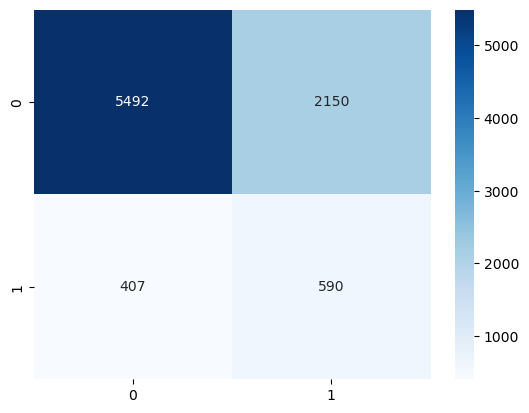

In [10]:
conf_matrix = sklearn.metrics.confusion_matrix(y_testset, tree_predictions)
heat_map = sb.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt='d')
classification = sklearn.metrics.classification_report(y_testset, tree_predictions)
print(classification)

Zur Einordnung der Ergebnisse sollten folgende Punkte betrachtet werden:
- Da der Datensatz sehr unausgewogen ist, bietet sich der Parameter Genauigkeit zur alleinigen Bewertung der Ergebnisse nicht an. Ein Modell, welcher alle Testdatensätze dem Ergebnis 0 zuordnen würde, hätte eine gute Genauigkeit, würde fachlich aber keinen Mehrwert bieten
- Trotz Oversampling der Testdaten hat das Modell eine bessere Performance bei der Erkennung von nicht erfolgreichen Datensätzen. 
- Die Zahl der False Positives (1946) ist fachlich als nicht so gravierend einzuordnen wie die Zahl der False Negatives (442): Würden die Modellergebnisse für die  Kampagne herangezogen, würden ca. 44% der historisch erfolgreich kontaktierten Personen nicht erkannt, was für die Bank eine deutliche Verschlechterung des Kampagnenergebnisses bedeutet hätte. Die Zahl der False Positives mag zwar deutlich größer wirken, fachlich bedeutet dies allerdings nur einen größeren Ressourcenbedarf zur Durchführung der Kampagne.
- Insgesamt wäre eine bessere Recall-Quote für erfolgreich kontaktierte Personen erstrebenswert. Hierfür könnten in weiteren Untersuchungen ein Undersampling anstelle des Oversampings der Testdaten sowie ein Fokus auf die Recall-Quote für erfolgreich kontaktierte Personen in der Scoring-Funktion der Parametrisierung des Baumes versucht werden. Es sollte dabei beachtet werden, dass dies vermutlich die Anzahl der False Positives weiter erhöhen wird - die ideale Kalibrierung hängt von den ganeuen fachlichen Anforderungen ab.


Um die Vorhersageergebnisse zu verbessern, könnten noch weitere Daten für das Modell benutzt werden. hierfür würden sich Daten zur wirtschafltichen Lage zum Zeitpunkt der Kampagne anbieten: Vermutlich hat die wirtschaftliche Situation der kontaktierten Personen zum Kampagnenzeitpunkt eine Auswirkung auf die Erfolgsquote. Um dies abzubilden, könnten Kennzahlen zur allgemeinen witrschaftlichen Lage wie Zinsindizes oder Zahlen zum BIP sowie Zahlen zum Arbeitsmarkt in das Modell aufgenommen werden.\
Die Modellergebnisse liefern zwei mögliche verschiedene Rückschlüsse: Einen Rückschluss darauf, welche Personen interessiert an dem angebotenen Finanzprodukt sind, und einen Rückschluss darauf, welche Personen für eine telefonische (oder generelle) Marketetingkampagne empfänglich sind. Diese Rückschlüsse lassen sich auf die Vermarktung anderer Finanzprodukte per Telefon übertragen (Personen, die generell empfänglich für solche Kampagnen sind, sind möglicherweise bessere Zielpersonen für weitere Kampagnen zum Verkauf anderer Finanzprodukte). Auch eine Übertragung auf andere Formen der Vermarktung ist denkbar: Bespielsweise könnte ein Abgleich von empfänglichen Personengruppen mit der Zuschauerschaft von Fernsehprogrammen für eine gezieltere Vermarktung von Finanzprodukten über Fernsehmarketing erfolgsversprechend sein.